<a href="https://colab.research.google.com/github/dileepkumar6017/PREDICTING-30-DAY-HOSPITAL-READMISSION-RISK-USING-MACHINE-LEARNING/blob/main/Data_Science_Project_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.impute import KNNImputer
from sklearn.calibration import CalibratedClassifierCV

In [ ]:
# Load dataset
file_path = 'readmission.csv'
df = pd.read_csv(file_path)

In [ ]:
# View dataset info
print("First 5 rows of the dataset:")
print(df.head())
print("\nShape of the dataset (rows, columns):", df.shape)
print("\nData types of each column:")
print(df.dtypes)
print("\nNumber of missing values in each column:")
print(df.isnull().sum())
print("\nCount of '?' values in each column:")
print((df == '?').sum())

# Handle missing values
df = df.replace('?', np.nan)

# Store original feature distributions for comparison
original_dist = df[['race', 'diag_1', 'diag_2', 'diag_3']].describe()

# KNN imputation for categorical columns
categorical_columns = ['race', 'diag_1', 'diag_2', 'diag_3']
df_encoded = pd.get_dummies(df[categorical_columns], drop_first=True)
imputer = KNNImputer(n_neighbors=5)
df_encoded_imputed = pd.DataFrame(imputer.fit_transform(df_encoded), columns=df_encoded.columns, index=df.index)
# Reverse one-hot encoding to original categorical values
for col in categorical_columns:
    df[col] = df_encoded_imputed.filter(like=col).idxmax(axis=1).str.replace(f'{col}_', '')

# Drop columns with excessive missing values
columns_to_drop = ['weight', 'payer_code', 'medical_specialty', 'max_glu_serum', 'A1Cresult']
df = df.drop(columns=columns_to_drop, axis=1)

# Drop rows with remaining missing values
df = df.dropna()

# Compare feature distributions post-imputation
print("\nPre-imputation distributions:")
print(original_dist)
print("\nPost-imputation distributions:")
print(df[categorical_columns].describe())

First 5 rows of the dataset:
   encounter_id  patient_nbr             race  gender      age weight  \
0       2278392      8222157        Caucasian  Female   [0-10)      ?   
1        149190     55629189        Caucasian  Female  [10-20)      ?   
2         64410     86047875  AfricanAmerican  Female  [20-30)      ?   
3        500364     82442376        Caucasian    Male  [30-40)      ?   
4         16680     42519267        Caucasian    Male  [40-50)      ?   

   admission_type_id  discharge_disposition_id  admission_source_id  \
0                  6                        25                    1   
1                  1                         1                    7   
2                  1                         1                    7   
3                  1                         1                    7   
4                  1                         1                    7   

   time_in_hospital  ... citoglipton insulin  glyburide-metformin  \
0                 1  ...          No

In [ ]:
# Drop unnecessary columns
df = df.drop(['encounter_id', 'patient_nbr'], axis=1)

# Drop duplicates
df = df.drop_duplicates()

# Relax filtering to increase sample size
df = df[df['admission_type_id'].isin([1, 2, 3, 4, 5])]  # Include more admission types
df = df[(df['time_in_hospital'] >= 1) & (df['time_in_hospital'] <= 30)]  # Extend to 30 days

# Create binary target
df['readmit_30'] = df['readmitted'].apply(lambda x: 1 if x == '<30' else 0)
df = df.drop('readmitted', axis=1)

# One-hot encode categorical columns
categorical_columns = ['race', 'gender', 'age', 'admission_type_id', 'discharge_disposition_id',
                      'admission_source_id', 'change', 'diabetesMed', 'metformin', 'repaglinide',
                      'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
                      'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
                      'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton',
                      'insulin', 'glyburide-metformin', 'glipizide-metformin',
                      'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone']
df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

# Feature engineering
df['total_visits'] = df['number_outpatient'] + df['number_emergency'] + df['number_inpatient']
df['comorbidity_count'] = df[['diag_1', 'diag_2', 'diag_3']].notnull().sum(axis=1)
df = df.drop(['diag_1', 'diag_2', 'diag_3'], axis=1)

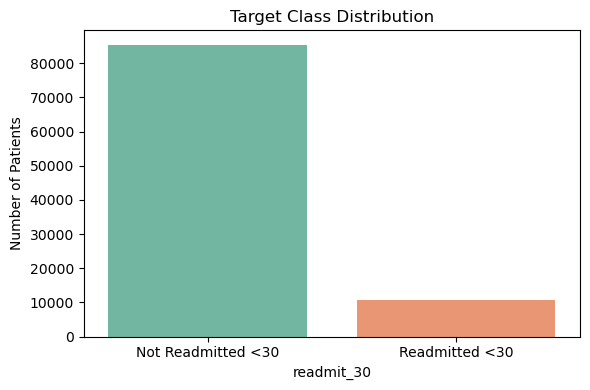

In [ ]:
# Class Distribution of the Target Variable
readmit_counts = df['readmit_30'].value_counts().reset_index()
readmit_counts.columns = ['readmit_30', 'count']
readmit_counts['readmit_30'] = readmit_counts['readmit_30'].map({0: 'Not Readmitted <30', 1: 'Readmitted <30'})

# Bar plot
plt.figure(figsize=(6, 4))
sns.barplot(data=readmit_counts, x='readmit_30', y='count', hue='readmit_30', palette='Set2', legend=False)
plt.ylabel('Number of Patients')
plt.title('Target Class Distribution')
plt.tight_layout()
plt.show()

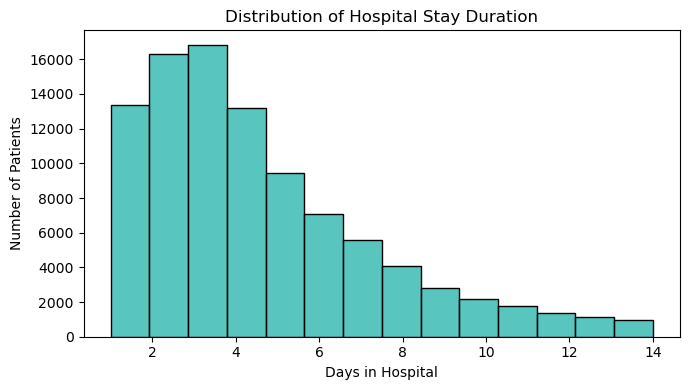

In [ ]:
# Distribution of Hospital Stay Duration
plt.figure(figsize=(7, 4))
sns.histplot(df['time_in_hospital'], bins=14, kde=False, color='lightseagreen')
plt.title('Distribution of Hospital Stay Duration')
plt.xlabel('Days in Hospital')
plt.ylabel('Number of Patients')
plt.tight_layout()
plt.show()

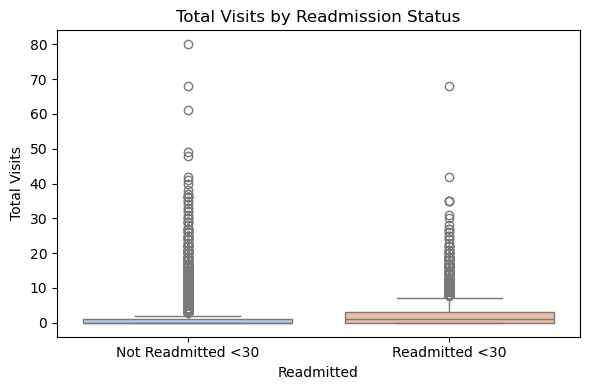

In [ ]:
# Total Visits by Readmission Status
plt.figure(figsize=(6, 4))
sns.boxplot(x='readmit_30', y='total_visits', data=df, hue='readmit_30', palette='coolwarm', legend=False)
plt.xticks([0, 1], ['Not Readmitted <30', 'Readmitted <30'])
plt.title('Total Visits by Readmission Status')
plt.xlabel('Readmitted')
plt.ylabel('Total Visits')
plt.tight_layout()
plt.show()


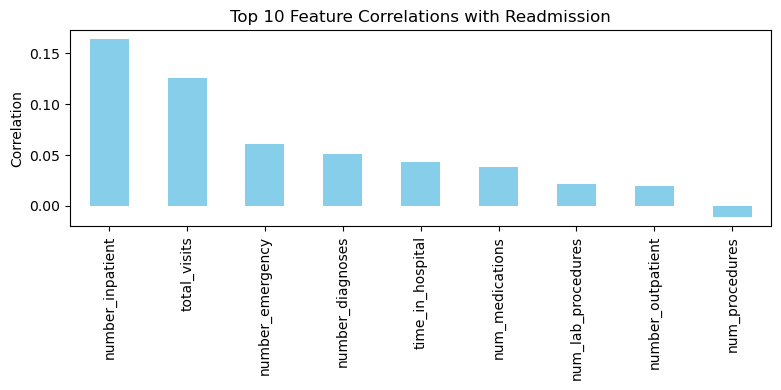

In [ ]:
# Select numeric columns excluding the target
numeric_cols = df.select_dtypes(include=['int64', 'float64']).drop('readmit_30', axis=1)

# Drop columns with zero variance
numeric_cols = numeric_cols.loc[:, numeric_cols.std() != 0]

# Calculate correlation with target
correlations = numeric_cols.corrwith(df['readmit_30']).dropna().sort_values(ascending=False)

# Plot top 10 correlations
plt.figure(figsize=(8, 4))
correlations.head(10).plot(kind='bar', color='skyblue')
plt.title('Top 10 Feature Correlations with Readmission')
plt.ylabel('Correlation')
plt.tight_layout()
plt.show()

In [ ]:
# Summary Statistics of Numerical Features
summary_stats = df.describe()
print("Summary Statistics:")
print(summary_stats)

Summary Statistics:
       time_in_hospital  num_lab_procedures  num_procedures  num_medications  \
count      96134.000000        96134.000000    96134.000000     96134.000000   
mean           4.390029           42.588990        1.320906        15.991855   
std            2.979636           19.553619        1.697513         8.104007   
min            1.000000            1.000000        0.000000         1.000000   
25%            2.000000           31.000000        0.000000        10.000000   
50%            4.000000           44.000000        1.000000        15.000000   
75%            6.000000           56.000000        2.000000        20.000000   
max           14.000000          132.000000        6.000000        81.000000   

       number_outpatient  number_emergency  number_inpatient  \
count       96134.000000      96134.000000      96134.000000   
mean            0.376672          0.202946          0.637204   
std             1.282756          0.950156          1.264775   
min

In [ ]:
# Separate features and target
X = df.drop('readmit_30', axis=1)
y = df['readmit_30']

# Apply SMOTE and ADASYN for class balancing
smote = SMOTE(random_state=42)
adasyn = ADASYN(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)
X_adasyn, y_adasyn = adasyn.fit_resample(X, y)

# Scale numeric features
numeric_cols = X_smote.select_dtypes(include=['int64', 'float64']).columns
scaler = StandardScaler()
X_smote[numeric_cols] = scaler.fit_transform(X_smote[numeric_cols])
X_adasyn[numeric_cols] = scaler.fit_transform(X_adasyn[numeric_cols])

# Split data (use SMOTE for primary analysis)
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.2, random_state=42, stratify=y_smote)

In [ ]:
# Initialize models with hyperparameter tuning
models = {
    'Logistic Regression': GridSearchCV(LogisticRegression(max_iter=1000, random_state=42),
                                       {'C': [0.1, 1, 10]}, cv=3),
    'Random Forest': GridSearchCV(RandomForestClassifier(random_state=42),
                                  {'n_estimators': [50, 100], 'max_depth': [None, 10]}, cv=3),
    'Gradient Boosting': GridSearchCV(GradientBoostingClassifier(random_state=42),
                                     {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1]}, cv=3),
    'SVM': GridSearchCV(CalibratedClassifierCV(LinearSVC(random_state=42, max_iter=5000, dual='auto'), cv=3),
                        {'estimator__C': [0.1, 1]}, cv=3),  # Set dual='auto' and increase max_iter
    'KNN': GridSearchCV(KNeighborsClassifier(),
                        {'n_neighbors': [3, 5, 7]}, cv=3)
}

# Stacking ensemble
estimators = [(name, model) for name, model in models.items()]
stacking_model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(max_iter=1000, random_state=42))
models['Stacking'] = stacking_model

# Train and evaluate models
results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else np.zeros_like(y_pred)

    result = {
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_prob) if y_prob.any() else 0,
        'Pred': y_pred,
        'Prob': y_prob
    }
    results.append(result)

    print(f"\n{name} Evaluation:")
    print(f"Accuracy: {result['Accuracy']:.2f}")
    print(f"Precision: {result['Precision']:.2f}")
    print(f"Recall: {result['Recall']:.2f}")
    print(f"F1 Score: {result['F1 Score']:.2f}")
    print(f"ROC AUC: {result['ROC AUC']:.2f}")
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Logistic Regression Evaluation:
Accuracy: 0.91
Precision: 0.97
Recall: 0.84
F1 Score: 0.90
ROC AUC: 0.94
Confusion Matrix:
 [[16631   447]
 [ 2769 14309]]

Random Forest Evaluation:
Accuracy: 0.93
Precision: 0.98
Recall: 0.88
F1 Score: 0.93
ROC AUC: 0.96
Confusion Matrix:
 [[16720   358]
 [ 2062 15016]]

Gradient Boosting Evaluation:
Accuracy: 0.89
Precision: 0.96
Recall: 0.81
F1 Score: 0.88
ROC AUC: 0.93
Confusion Matrix:
 [[16494   584]
 [ 3287 13791]]

SVM Evaluation:
Accuracy: 0.90
Precision: 0.96
Recall: 0.84
F1 Score: 0.90
ROC AUC: 0.94
Confusion Matrix:
 [[16539   539]
 [ 2722 14356]]

KNN Evaluation:
Accuracy: 0.88
Precision: 0.84
Recall: 0.94
F1 Score: 0.88
ROC AUC: 0.94
Confusion Matrix:
 [[14001  3077]
 [ 1108 15970]]

Stacking Evaluation:
Accuracy: 0.93
Precision: 0.96
Recall: 0.89
F1 Score: 0.93
ROC AUC: 0.97
Confusion Matrix:
 [[16505   573]
 [ 1810 15268]]


In [ ]:
# Cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = []
for name, model in models.items():
    cv_scores = cross_val_score(model, X_smote, y_smote, cv=skf, scoring='f1')
    cv_results.append({'Model': name, 'Mean F1': cv_scores.mean()})
    print(f"{name} Mean F1 Score (CV): {cv_scores.mean():.2f}")

Logistic Regression Mean F1 Score (CV): 0.90
Random Forest Mean F1 Score (CV): 0.93
Gradient Boosting Mean F1 Score (CV): 0.88
SVM Mean F1 Score (CV): 0.89
KNN Mean F1 Score (CV): 0.88


In [ ]:
# Plot confusion matrices
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()
for i, (name, result) in enumerate(zip(models.keys(), results)):
    cm = confusion_matrix(y_test, result['Pred'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', ax=axes[i],
                xticklabels=['No Readmit', 'Readmit'], yticklabels=['No Readmit', 'Readmit'])
    axes[i].set_title(f'Confusion Matrix - {name}')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('True')
plt.tight_layout()
plt.show()

In [ ]:
# Plot ROC AUC curves
plt.figure(figsize=(8, 6))
for result in results:
    if result['ROC AUC'] > 0:
        fpr, tpr, _ = roc_curve(y_test, result['Prob'])
        plt.plot(fpr, tpr, label=f"{result['Model']} (AUC = {result['ROC AUC']:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Plot precision-recall curves with baseline and thresholds
plt.figure(figsize=(8, 6))
no_skill = len(y_test[y_test == 1]) / len(y_test)
plt.axhline(y=no_skill, color='k', linestyle='--', label='No Skill')
for name, model in models.items():
    if hasattr(model, 'predict_proba'):
        y_prob = model.predict_proba(X_test)[:, 1]
        precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
        plt.plot(recall, precision, label=f'{name}')
        for i in range(0, len(thresholds), len(thresholds)//5):
            plt.text(recall[i], precision[i], f'{thresholds[i]:.2f}', fontsize=8)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve with Thresholds')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Plot metrics comparison
metrics_df = pd.DataFrame(results)
metrics_df_melted = metrics_df.melt(id_vars='Model', var_name='Metric', value_name='Score')
plt.figure(figsize=(12, 6))
sns.barplot(data=metrics_df_melted, x='Metric', y='Score', hue='Model')
plt.title('Evaluation Metrics Comparison')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

In [ ]:
# Plot feature importance for Random Forest and Gradient Boosting
for name in ['Random Forest', 'Gradient Boosting']:
    model = models[name].best_estimator_ if name != 'Stacking' else models[name]
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        features = X_train.columns
        importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
        importance_df = importance_df.sort_values(by='Importance', ascending=False).head(15)

        plt.figure(figsize=(10, 6))
        bars = plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
        plt.xlabel('Feature Importance')
        plt.title(f'Top 15 Feature Importances - {name}')
        plt.gca().invert_yaxis()
        for bar in bars:
            width = bar.get_width()
            plt.text(width + 0.001, bar.get_y() + bar.get_height()/2, f'{width:.3f}', va='center')
        plt.tight_layout()
        plt.show()